In [17]:
### Goals
# 1. Create simple teams 
# 2. Have simple/damage bots battle with teams
# 3. Understand action space
# 4. Get dummy net to take actions in battle

"""
Run prior to NB:

cd pokemon-showdown
cp config/config-example.js config/config.js
node pokemon-showdown start --no-security
"""

'\nRun prior to NB:\n\ncd pokemon-showdown\ncp config/config-example.js config/config.js\nnode pokemon-showdown start --no-security\n'

In [18]:
# Notes:
# must have some EV's on mons
# would be nice to check if mon is valid without losing kernel

team_1 = """
Charizard @ Heavy-Duty Boots
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Timid Nature
- Roost
- Flamethrower
- Hurricane
- Toxic
"""
team_2 = """
Venusaur @ Life Orb
Ability: Chlorophyll
EVs: 252 SpA / 4 SpD / 252 Spe
Modest Nature
- Growth
- Giga Drain
- Weather Ball
- Sludge Bomb
"""
team_char = """
Charmander @ Leftovers
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Air Cutter
- Belly Drum
- Cut
- Ember
"""
team_embchar = """
Charmander @ Leftovers
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Ember
"""
team_bulb = """
Bulbasaur @ Leftovers
Ability: Overgrow
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Amnesia
- Energy Ball
- Outrage
- Charm
"""
team_squir = """
Squirtle @ Leftovers
Ability: Rain Dish
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Aqua Jet
- Bite
- Shell Smash
- Hail
"""
team_bliss = """
Blissey @ Heavy-Duty Boots
Ability: Natural Cure
EVs: 252 HP / 252 Def / 4 SpD
Bold Nature
- Seismic Toss
- Soft-Boiled
- Charm
- Aromatherapy
"""
team_champ = """
Machop @ Choice Scarf
Ability: Guts
EVs: 252 HP / 252 Def / 4 SpD
Bold Nature
- Brick Break
"""
team_punchmew = """
Mew @ Choice Specs
Ability: Synchronize
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Mega Punch
"""
team_slowking= """
Slowking @ Heavy-Duty Boots
Ability: Regenerator
EVs: 252 HP / 252 Def / 4 SpD
Bold Nature
- Psyshock
- Slack Off
"""
team_chartest = """
Charmander @ Oran Berry
Ability: Blaze
EVs: 252 Atk / 4 SpD / 252 Spe
Jolly Nature
- Ember
- Scratch
- Endure
"""
team_bulbtest = """
Bulbasaur @ Leftovers
Ability: Overgrow
EVs: 252 HP / 252 Def / 4 SpD
Relaxed Nature
- Growl
"""
team_mew = """
Mew @ Expert Belt
Ability: Synchronize
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Psychic
- Energy Ball
- Surf
"""
team_1v3test = """
Machoke @ Heavy-Duty Boots
Ability: Guts
EVs: 252 HP / 252 Def / 4 SpD
Relaxed Nature
- Leer
- Bulk Up
- Focus Energy

Whiscash @ Heavy-Duty Boots
Ability: Oblivious
EVs: 252 HP / 252 Def / 4 SpD
Relaxed Nature
- Rain Dance
- Dragon Dance
- Tickle

Torkoal @ Heavy-Duty Boots
Ability: White Smoke
EVs: 252 HP / 252 Def / 4 SpD
Relaxed Nature
- Curse
- Iron Defense
"""

In [19]:
import asyncio
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tring to squelch bad poke-env move outputs (e.g.: locked into outrage)
import logging
logging.getLogger("poke_env").setLevel(logging.CRITICAL)

# Global variable for coarse graining hp states
NUM_HP_BINS = 4

In [20]:
from poke_env import Player, RandomPlayer
from simple_dqn import DQN

In [21]:
from poke_env.player import RandomPlayer

class NoSwitchRandomPlayer(RandomPlayer):
    def choose_move(self, battle):
        # If the Pokémon can attack, force it to use a move
        if battle.available_moves:
            return self.create_order(random.choice(battle.available_moves))
        
        # Otherwise, switch (only if no valid moves are left)
        return self.choose_random_move(battle)

In [22]:
# From poke-env docs

class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        # Chooses a move with the highest base power when possible
        if battle.available_moves:
            # Iterating over available moves to find the one with the highest base power
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            # Creating an order for the selected move
            return self.create_order(best_move)
        else:
            # If no attacking move is available, perform a random switch
            # This involves choosing a random move, which could be a switch or another available action
            return self.choose_random_move(battle)

In [23]:
class DebugPlayer(RandomPlayer):
    def choose_move(self, battle):
        # Print turn number
        print(f"Turn: {battle.turn}")

        # Print available moves
        print(f"Available moves: {[move.id for move in battle.available_moves]}")

        # Check battle has started
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon
 
        # Extract key battle info
        state = {
            #"turn": battle.turn,
            "your_hp": int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else None,
            "your_status": battle.active_pokemon.status if your_pokemon else None,
            "your_moves": [move.id for move in battle.available_moves] if your_pokemon else None,
            "opponent_hp": int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else None,
            "opponent_status": battle.opponent_active_pokemon.status if opponent_pokemon else None
        }

        # Get type effectiveness
        moves_dmg_multiplier = np.ones(4)
        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # Print the state info
        # print(f"State: {state}")

        return super().choose_move(battle)  # Act as a random player

In [24]:
# adjusted from poke-env docs
# dummy player that observes the battle and passes state to dqn for random action

class DummyRLPlayer(Player):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model  # Store DQN model
        
    def choose_move(self, battle):
        # Check battle has started and get hp's
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon

        your_hp = int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else -1
        opponent_hp = int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else -1

        # Get available move powers
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                moves_base_power[i] = (
                    move.base_power / 100
                )  # Simple rescaling to facilitate learning
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # test if state has worked correctly
        state = np.concatenate(
            [
                moves_base_power,
                moves_dmg_multiplier,
                [your_hp, opponent_hp],
            ]
        )

        # Create state vector
        state = np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor

        # Get Q-values from DQN
        with torch.no_grad():
            q_values = self.model(state_tensor)

        # "Best" move is just random b/c dqn doesn't train
        best_move_idx = torch.argmax(q_values).item()
        available_moves = battle.available_moves

        # Simple check, doesn't factor pp yet
        if available_moves and best_move_idx < len(available_moves):
            return self.create_order(available_moves[best_move_idx])
        else:
            return self.choose_random_move(battle)  # Fallback if move index is invalid


    def compute_reward(self, battle) -> float:
        pass

In [25]:
# Testing simple RL player
# add dqn model to player class

class SimpleRLPlayer(Player):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prev_opponent_hp = 1.0 # cludge
        self.model = model
        self.memory = deque(maxlen=10000)  # Experience replay buffer
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        
    def choose_move(self, battle):
        # Convert battle state into a vector
        state = self.get_state_vector(battle)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get Q-values and pick best move
        with torch.no_grad():
            q_values = self.model(state_tensor)
        
        # Best move now informed by RL
        best_move_idx = torch.argmax(q_values).item()
        available_moves = battle.available_moves

        # Compute reward for action
        reward = self.compute_reward(battle)
        next_state = self.get_state_vector(battle)  # Next state (after move)
        done = battle.finished  # Check if the battle is over
        action_idx = best_move_idx  # Action taken

        # Store state-action
        self.memory.append((state, action_idx, reward, next_state, done))

        # Simple check, doesn't factor pp yet
        if available_moves and best_move_idx < len(available_moves):
            return self.create_order(available_moves[best_move_idx])
        else:
            return self.choose_random_move(battle)  # Fallback move
        
    def get_state_vector(self, battle):
        ### Convert battle info to state vector
        # State info is very simple atm
        # move bp, type effectiveness, and hp values
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon

        your_hp = int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else -1
        opponent_hp = int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else -1

        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)

        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                moves_base_power[i] = move.base_power / 100
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # print(f"State: {np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])}")
        return np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])

    def train(self, batch_size=32):
        ###Updates the DQN model using stored experience
        if len(self.memory) < batch_size:
            return  # Don't train until we have enough experiences

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)

        # Compute current Q-values
        q_values = self.model(states).gather(1, actions)

        # Compute next Q-values using target network
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)

        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss and update model
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def compute_reward(self, battle) -> float:
        reward = 0

        # Directly reward the agent for HP loss in opponent
        if battle.opponent_active_pokemon:
            damage_dealt = self.prev_opponent_hp - battle.opponent_active_pokemon.current_hp_fraction
            reward += np.power(damage_dealt * 10, 2)  # Scale reward for damage dealt

        # Large reward for winning
        if battle.won:
            reward += 100

        # Update previous HP for tracking
        self.prev_opponent_hp = battle.opponent_active_pokemon.current_hp_fraction if battle.opponent_active_pokemon else 1.0

        return reward


"""    def compute_reward(self, battle) -> float:
        reward = 0

        # Reward for reducing opponent HP
        if battle.opponent_active_pokemon:
            reward += np.power((1 - battle.opponent_active_pokemon.current_hp_fraction), 1) * 5

        # Reward for maintaining hp
        if battle.active_pokemon:
            if battle.active_pokemon.current_hp_fraction < .5:
                reward += np.power((battle.active_pokemon.current_hp_fraction), 2) * 100

        # Reward for dealing the final blow
        if battle.opponent_active_pokemon and battle.opponent_active_pokemon.fainted:
            reward += 10

        # Reward for winning
        if battle.won:
            #print("win")
            reward += 1000

        return reward"""


'    def compute_reward(self, battle) -> float:\n        reward = 0\n\n        # Reward for reducing opponent HP\n        if battle.opponent_active_pokemon:\n            reward += np.power((1 - battle.opponent_active_pokemon.current_hp_fraction), 1) * 5\n\n        # Reward for maintaining hp\n        if battle.active_pokemon:\n            if battle.active_pokemon.current_hp_fraction < .5:\n                reward += np.power((battle.active_pokemon.current_hp_fraction), 2) * 100\n\n        # Reward for dealing the final blow\n        if battle.opponent_active_pokemon and battle.opponent_active_pokemon.fainted:\n            reward += 10\n\n        # Reward for winning\n        if battle.won:\n            #print("win")\n            reward += 1000\n\n        return reward'

In [26]:
# Testing simple RL player
# add dqn model to player class

class SuperEffectiveRLPlayer(Player):
    def __init__(self, model, print_out, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.print_out = print_out
        self.prev_opponent_hp = 1.0 # cludge
        self.last_move_used = None  # cludge
        self.num_opp_fainted = 0    ### SUPER HUGE CLUDGE below
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.done = None
        self.turn_taken = False     ### END SUPER HUGE CLUDGE
        self.model = model
        self.memory = deque(maxlen=10000)  # Experience replay buffer
        self.gamma = 0.1
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

    def choose_move(self, battle):
        # if not hasattr(self, "state"):
        #     "Should never run but sometimes does"
        #     print(" i had to reinit vars ")
        #     self.state = None
        #     self.num_opp_fainted = 0
        #     self.turn_taken = False
        if self.print_out:
            print("\n====================================================================\n")
            print(f"Turn: {battle.turn}")
        # if self.state is None:
        #     self.state = self.get_state_vector(battle)
        #     print(self.state)
        # elif self.state is not None:
        #     state = self.state
        #     next_state = self.get_state_vector(battle)
        #     reward = self.compute_reward(battle)
        #     done = battle.finished

        #     # **Store experience tuple (s, a, r, s', d)**
        #     self.memory.append((self.state, self.last_move_used, reward, next_state, done))
        #     print(f"\nstate: {self.state}\naction: {action}\nreward: {reward}\nnext state: {next_state}\ndone: {done}")

        # self.num_opp_fainted = sum(1 for mon in battle.opponent_team.values() if mon.fainted)

        if not hasattr(self, "taken_turn"):
            if self.print_out: print(f"no action, turn: {battle.turn}")
            self.taken_turn = False
            self.state = self.get_state_vector(battle)
        else:
            if self.print_out: print(f"move made: {battle.turn}")
            self.taken_turn = True
        
        # print(f"num ko'd: {self.num_opp_fainted}")
        available_moves = battle.available_moves

        if available_moves:
            # Get the best move based on Q-values
            state = self.get_state_vector(battle)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            
            best_move_idx = torch.argmax(q_values).item()
            if best_move_idx < len(available_moves):
                chosen_move = available_moves[best_move_idx]
                action = best_move_idx  # Store action as index
            else: 
                chosen_move = random.choice(available_moves)  # Fallback
                action = available_moves.index(chosen_move)  

            # Execute the move
            action = np.mod(battle.turn, 3)                 # test action storage
            if self.print_out: print(f"Current turn action taken: {action}")   # test action storage
            order = self.create_order(chosen_move)

            # if self.turn_taken:
            # **Observe the next state and reward**
            next_state = self.get_state_vector(battle)
            reward = self.compute_reward(battle)
            done = battle.finished

            # **Store experience tuple (s, a, r, s', d)**
            if self.taken_turn:
                # self.next_state = state # this is extra
                self.memory.append((self.state, self.action, reward, next_state, done))
                self.state = next_state
                self.action = action # saves the action from "last turn"
                if self.print_out: print(f"turn: {battle.turn}")
                # print(f"\nstate: {state}\naction: {action}\nreward: {reward}\nnext state: {next_state}\ndone: {done}")
                if self.print_out:
                    print(f"\nstate: {self.memory[-1][0]}\naction: {self.memory[-1][1]}\nreward: {self.memory[-1][2]}\nnext state: {self.memory[-1][3]}\ndone: {self.memory[-1][4]}")
            else:
                if self.print_out:
                    print("first turn - no memory updates")
                    print(f"reward: {reward}")
                    print(f"action: {action}")
                self.action = action
                if self.print_out:
                    print(f"\nstate: {state}\naction: {action}\nreward: {reward}\nnext state: {next_state}\ndone: {done}")

            # Save last move used for reward computation
            self.last_move_used = chosen_move  

            return order

        return self.choose_random_move(battle)  # No available moves, pick randomly

        
    def get_state_vector(self, battle):
        ### Convert battle info to state vector
        # State info is very simple atm
        # move bp, type effectiveness, and hp values
        # reward for knocking out is always delayed? adding opponent ko'd prev turn to state
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon

        num_fainted = sum(1 for mon in battle.opponent_team.values() if mon.fainted)
        if self.print_out: print(f"defeated: {num_fainted}, {self.num_opp_fainted}")

        your_hp = int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else -1
        opponent_hp = int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else -1

        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)

        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                moves_base_power[i] = move.base_power / 100
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # print(f"State: {np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])}")
        return np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp, num_fainted - self.num_opp_fainted]])

    def train(self, batch_size=32):
        # print('training!')
        ###Updates the DQN model using stored experience
        if len(self.memory) < batch_size:
            return  # Don't train until we have enough experiences

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)

        # print(f"\nstate: {states}\naction: {actions}\nreward:{rewards}\nnext state: {next_states}\ndone: {dones}")

        # Compute current Q-values
        q_values = self.model(states).gather(1, actions)

        # Compute next Q-values using target network
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)

        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss and update model
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def compute_reward(self, battle):
        reward = 0
        num_fainted = sum(1 for mon in battle.opponent_team.values() if mon.fainted)

        if battle.opponent_active_pokemon:
            # print(battle.opponent_active_pokemon.boosts)
            if num_fainted == self.num_opp_fainted:
                "Recall: binning HP to reduce state space size"
                # print(f"prev hp: {self.prev_opponent_hp}\nnew hp: {battle.opponent_active_pokemon.current_hp_fraction}")
                damage_dealt = self.prev_opponent_hp - battle.opponent_active_pokemon.current_hp_fraction
                # print(f"turn # {battle.turn} damage_dealt: {damage_dealt}")
                reward += np.power(damage_dealt * 10, 2)
                # print(f"\ndamage dealt: {damage_dealt}\nreward: {reward}\n")

                # # Reward super-effective moves using stored last move
                # if self.last_move_used and battle.opponent_active_pokemon:
                #     move_effectiveness = battle.opponent_active_pokemon.damage_multiplier(self.last_move_used)
                #     if move_effectiveness > 1.0:
                #         reward += 35
                #     else:
                #         reward -= 25  # Penalize weak moves
            else:
                self.num_opp_fainted = num_fainted
                reward += 100

        # print(f"Opponent status: {battle.opponent_active_pokemon.status}")
        if battle.won and self.prev_opponent_hp > .75:
            reward += 500
        elif battle.won and self.prev_opponent_hp > .35:
            reward += 250
        else:
            if self.print_out: print("battle ended with low % ko")

        self.prev_opponent_hp = battle.opponent_active_pokemon.current_hp_fraction if battle.opponent_active_pokemon else 1.0
        if self.print_out: print(f"Turn reward: {reward}")
        return reward



In [27]:
async def random_player_battle(team_1, team_2, n_battles):
    p1 = DebugPlayer(battle_format="gen8ou", team=team_1)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_2)

    await p1.battle_against(p2, n_battles=n_battles)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [28]:
async def maxdam_player_battle(team_1, team_2, n_battles):
    p3 = MaxDamagePlayer(battle_format="gen8ou", team=team_1)
    p4 = MaxDamagePlayer(battle_format="gen8ou", team=team_2)

    await p3.battle_against(p4, n_battles=n_battles)

    for battle_tag, battle in p3.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 3 played battle: ", battle_tag, " and ", won_txt)

In [29]:
# Runs one battle with players in showdown local server
test = False

if test:
    #p1 = DebugPlayer(battle_format="gen8ou", team=team_bulb)
    model = DQN() 
    p1 = SimpleRLPlayer(model, battle_format="gen8ou", team=team_bliss)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_bliss)

    await p1.battle_against(p2, n_battles=1)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [30]:
VERBOSE = False
NUM_EPISODES = 10000
NUM_BATTLES = 1
# NUM_BATTLES seems independent of initializing players? they have their own battle then more results are here confusingly....

model = DQN() ### Need to add input/output sizes etc..................!
agent = SuperEffectiveRLPlayer(model, print_out=VERBOSE, battle_format="gen8ou", team=team_mew)
opponent = NoSwitchRandomPlayer(battle_format="gen8ou", team=team_1v3test)
#opponent = RandomPlayer(battle_format="gen8ou", team=team_bulbtest)

n_won_battles = 0
win_rates = []
batch_n_won_battles = 0
batch_win_rates = []
episode_rewards = []

for episode in tqdm(range(NUM_EPISODES), desc="Training Progress"):
    # print(f"\nEpisode: {episode}")
    await agent.battle_against(opponent, n_battles=NUM_BATTLES)

    total_reward = 0
    # if episode % 10 == 0:
    #     print(f"Episode {episode}: Move Usage Stats: {agent.move_usage_counts}")
    # if episode % 50 == 0:  # Log every 50 episodes
    #     sample_state = torch.tensor(agent.memory[0][0], dtype=torch.float32).unsqueeze(0)
    #     q_values = agent.model(sample_state)
    #     print(f"Episode {episode} | Sample Q-Values: {q_values.tolist()}")
    num_obs = 11
    display_q_vals = False
    if episode % 250 == 0 and display_q_vals:
        sample_states = [torch.tensor(agent.memory[i][0], dtype=torch.float32).unsqueeze(0) for i in range(min(num_obs, len(agent.memory)))]
        for i, state in enumerate(sample_states):
            q_values = agent.model(state)
            print(f"Episode {episode} | Sample State {i} Q-Values: {q_values.tolist()}")

    # Save the experience
    for battle in agent.battles.values():
        if VERBOSE:
            print("\nEND OF BATTLE\n")
            print(battle.won)
        state = agent.state
        reward = agent.compute_reward(battle)
        next_state = agent.get_state_vector(battle)  # Next state (same for now)
        done = battle.finished  # Check if battle ended
        action = agent.action
        agent.memory.append((state, action, reward, next_state, done))
        if VERBOSE:
            print(f"\nstate: {state}\naction: {action}\nreward: {reward}\nnext state: {next_state}\ndone: {done}")
        # print(agent.memory)
        #total_reward += reward  # Sum rewards for this episode
        total_reward += sum(r for _, _, r, _, _ in agent.memory)
        total_reward -= battle.turn * 20
    # Train the model
    agent.train(batch_size=32)

    # Check in on outputs
    if episode < -50:
        print(f"Episode {episode} - {agent.n_won_battles}")

    # Store win rate
    n_won_battles += agent.n_won_battles
    win_rate = n_won_battles / (NUM_BATTLES * (episode + 1))
    win_rates.append(win_rate)
    
    # Store total reward for episode
    episode_rewards.append(total_reward)

    # Reset battles
    agent.reset_battles()

# Save trained model if desired
#torch.save(model.state_dict(), "dqn_model.pth")


Training Progress: 100%|██████████| 10000/10000 [04:51<00:00, 34.32it/s]


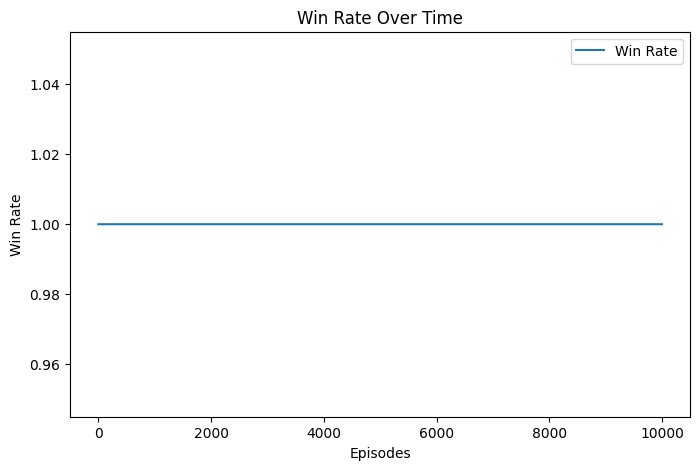

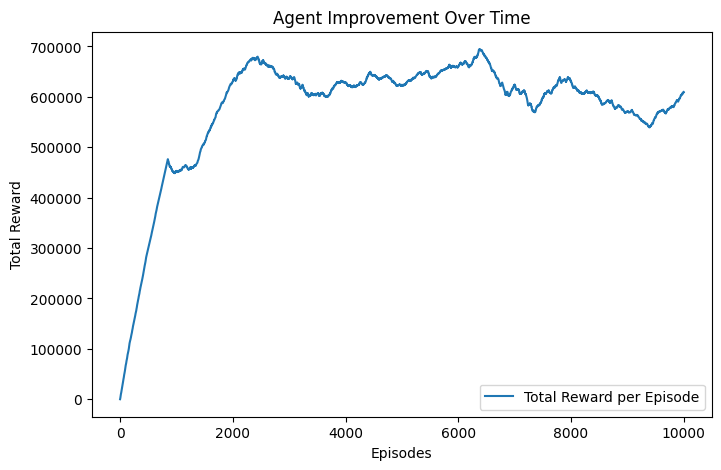

In [31]:
# Plot Win Rate Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), win_rates, label="Win Rate")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.title("Win Rate Over Time")
plt.legend()
plt.show()

# Plot Reward Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Agent Improvement Over Time")
plt.legend()
plt.show()

In [32]:
total_reward

np.float64(609610.3100000077)